# Load Dependencies


In [119]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import torch

# import pyciemss
# from pyciemss.PetriNetODE.interfaces import setup_model, reset_model, intervene, sample, calibrate, optimize, load_petri_model
# import mira
from pyciemss.PetriNetODE.interfaces import setup_model, intervene, sample, calibrate, optimize
from pyciemss.utils import get_tspan
from pyciemss.utils import setup_ax, plot_predictive, plot_trajectory, plot_intervention_line, plot_ouu_risk

from pyciemss.risk.risk_measures import alpha_quantile, alpha_superquantile
from pyciemss.risk.ouu import computeRisk, solveOUU
from pyciemss.risk.qoi import scenario2dec_sample_average
import numpy as np
import time

import warnings
warnings.filterwarnings('ignore')

import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup Parameters (need to clean up what is indicated as "bad" or "wrong" below)


In [2]:
full_tspan = get_tspan(1, 89, 89) #bad idea

num_samples = 10

# Total population, N.
N = 100000.0
# Initial number of infected and recovered individuals, I0 and R0.
V0, I0, Iv0, R0 = 0., 81.0, 0., 0. #may want to revisit this choice, consider setting I0 to 1 (there will not be zero recovered people when there are 81 infectious people)
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - Iv0 - V0 - R0

# 18 - 24 year olds
I_obs_data = [81.47, 84.3, 86.44, 89.66, 93.32, 94.1, 96.31] #these numbers make no sense, why not use whole numbers?
plot_I_obs = dict(I_obs=torch.tensor(I_obs_data))
I_obs = [(float(i+1), dict(I_obs=obs/N)) for i, obs in enumerate(I_obs_data)]

observed_tspan = get_tspan(1, len(I_obs), len(I_obs)) #also bad

# named_initial_state = {
#     "S": torch.as_tensor(S0),
#     "V": torch.as_tensor(V0),
#     "I": torch.as_tensor(I0),
#     "I_v": torch.as_tensor(Iv0),
#     "R": torch.as_tensor(R0),
# }

# named_final_state = {
#     "S": torch.as_tensor(S0),
#     "V": torch.as_tensor(V0),
#     "I": I_obs[-1],
#     "I_v": torch.as_tensor(Iv0),
#     "R": torch.as_tensor(R0),
# }
I_obs

[(1.0, {'I_obs': 0.0008147}),
 (2.0, {'I_obs': 0.000843}),
 (3.0, {'I_obs': 0.0008644}),
 (4.0, {'I_obs': 0.0008966}),
 (5.0, {'I_obs': 0.0009331999999999999}),
 (6.0, {'I_obs': 0.000941}),
 (7.0, {'I_obs': 0.0009631})]

# Probabilistic Forecasting - Ignoring Historical Data

## Load the model

In [3]:
from pyciemss.PetriNetODE.models import MIRA_I_obs_with_scaled_Gaussian_noise
model_json = '../../test/models/SVIIvR_mira.json'
petri_net_ode_model = MIRA_I_obs_with_scaled_Gaussian_noise.from_mira(model_json)
petri_net_ode_model.total_population = N
petri_net_ode_model.data_reliability = 4.0
petri_net_ode_model

MIRA_I_obs_with_scaled_Gaussian_noise(
	beta = Uniform(low: 0.18000000715255737, high: 0.2199999988079071),
	betaV = Uniform(low: 0.03375000134110451, high: 0.04125000163912773),
	nu = Uniform(low: 0.0044999998062849045, high: 0.005499999970197678),
	gamma = Uniform(low: 0.1574999988079071, high: 0.19249999523162842),
	gammaV = Uniform(low: 0.22499999403953552, high: 0.2750000059604645),
	total_population = 100000.0,
	data_reliability = 4.0
)

## Initialize

In [4]:
initialized_petri_net_ode_model = setup_model(petri_net_ode_model, start_time=0.0, start_state=dict(S=S0, V=V0, I=I0, I_v=Iv0, R=R0))
#this is giving the wrong documentation string

## Q: "What likely future outcomes does our model imply?"

### Sample a single trajectory from the prior distribution

In [5]:
single_prior = sample(initialized_petri_net_ode_model, timepoints=full_tspan, num_samples=1)
single_prior['I_obs'] = single_prior['I_sol'] + single_prior['I_v_sol']

### Sample 100 trajectories from the prior distribution

In [6]:
prior_prediction = sample(initialized_petri_net_ode_model, timepoints=timepoints_qoi, num_samples=100)
prior_prediction['I_obs'] = prior_prediction['I_sol'] + prior_prediction['I_v_sol']

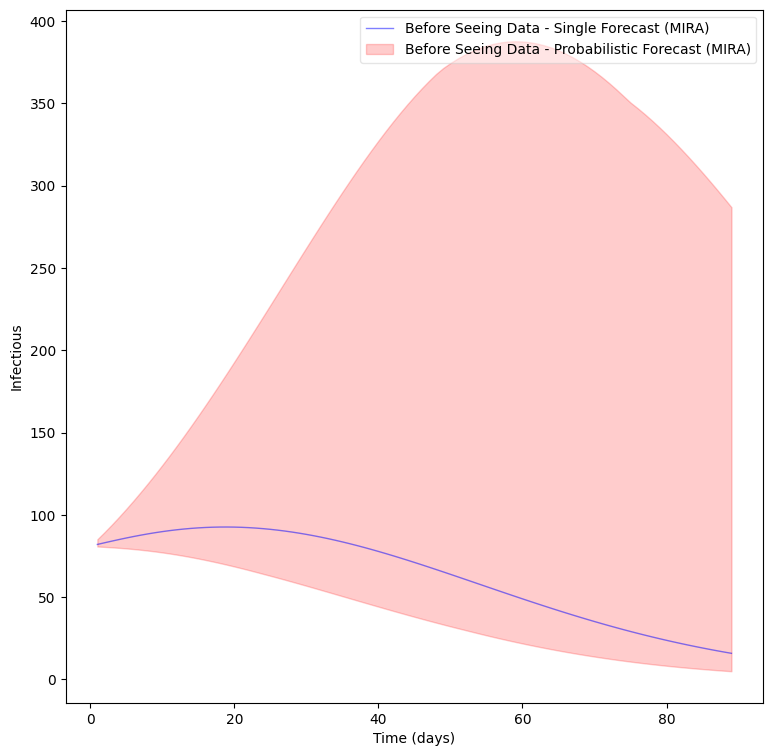

In [7]:
ax = plot_trajectory(single_prior, timepoints_qoi, ax=setup_ax(), color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast (MIRA)")
ax = plot_predictive(prior_prediction, full_tspan, ax=ax, label="Before Seeing Data - Probabilistic Forecast (MIRA)", color="red", alpha=0.2)

## Forecasting - Incorporating Historical Data

### Calibration

In [8]:
data = [(float(i+1), dict(I_obs=obs)) for i, obs in enumerate([81.47, 84.3, 86.44, 89.66, 93.32, 94.1, 96.31])]
calibrated_parameters = calibrate(initialized_petri_net_ode_model, data=data, verbose=True)

iteration 0: loss = 27.183197736740112
iteration 25: loss = 23.785506010055542
iteration 50: loss = 19.826377630233765
iteration 75: loss = 17.44716715812683
iteration 100: loss = 17.64667820930481
iteration 125: loss = 17.483870267868042
iteration 150: loss = 17.9587459564209
iteration 175: loss = 17.811434507369995
iteration 200: loss = 16.015715837478638
iteration 225: loss = 17.33594584465027
iteration 250: loss = 16.64981198310852
iteration 275: loss = 18.193193674087524
iteration 300: loss = 15.041191816329956
iteration 325: loss = 16.066094160079956
iteration 350: loss = 14.732128858566284
iteration 375: loss = 16.741403341293335
iteration 400: loss = 16.12403893470764
iteration 425: loss = 16.78213143348694
iteration 450: loss = 16.729868173599243
iteration 475: loss = 16.442939043045044
iteration 500: loss = 17.735174417495728
iteration 525: loss = 16.345625162124634
iteration 550: loss = 15.521985292434692
iteration 575: loss = 15.612066507339478
iteration 600: loss = 16.1344

## Generated samples from the calibrated parameters

In [9]:
new_tspan = get_tspan(len(I_obs), 89, 89-len(I_obs))    # Where is this supposed to be used
posterior_prediction = sample(initialized_petri_net_ode_model,  inferred_parameters=calibrated_parameters, timepoints=timepoints_qoi, num_samples=100)
posterior_prediction['I_obs'] = posterior_prediction['I_sol'] + posterior_prediction['I_v_sol']
single_posterior = sample(initialized_petri_net_ode_model,  inferred_parameters =calibrated_parameters, timepoints=full_tspan, num_samples=1)
single_posterior['I_obs'] = single_posterior['I_sol'] + single_posterior['I_v_sol']

## Q: "What future outcomes are likely given the data we've seen?"

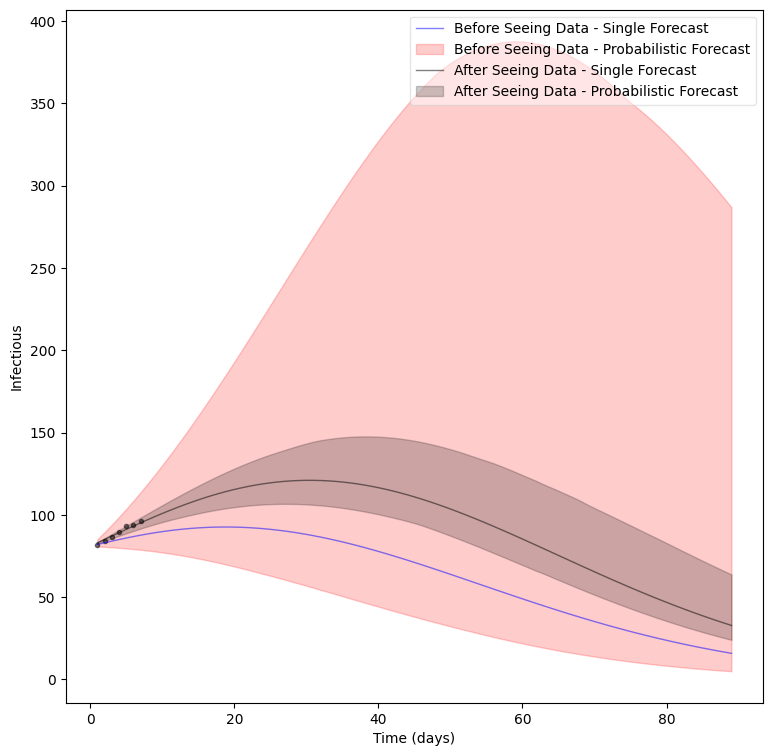

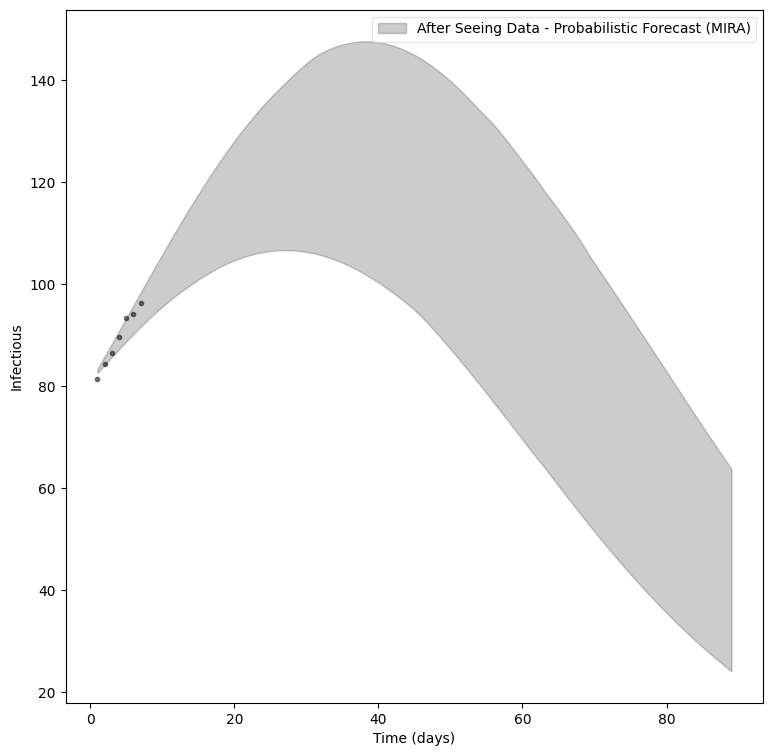

In [10]:
ax = plot_trajectory(plot_I_obs, get_tspan(1, len(I_obs), len(I_obs)), ax=setup_ax())
ax = plot_trajectory(single_prior, full_tspan, ax=ax, color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast")
ax = plot_predictive(prior_prediction, full_tspan, ax=ax, label="Before Seeing Data - Probabilistic Forecast", color="red")
ax = plot_trajectory(single_posterior, full_tspan, ax=ax, marker='', lw=1., label="After Seeing Data - Single Forecast")
ax = plot_predictive(posterior_prediction, full_tspan, ax=ax, label="After Seeing Data - Probabilistic Forecast")
ax = plot_trajectory(plot_I_obs, get_tspan(1,len(I_obs), len(I_obs)), ax=setup_ax())
ax = plot_predictive(posterior_prediction, full_tspan, ax=ax, label="After Seeing Data - Probabilistic Forecast (MIRA)")

# Probabilistic Forecasting - Exploring Possible Interventions



## Q: "What would happen if we set the vaccination rate parameter, $\nu$?"


In [11]:
# note that we cannot intervene at a previously existing timepoint, or odeint will complain.
rate_parameter_intervention = [(7.5, "nu", 0.01)]
# intervened_parameter_model = do(plotting_ode_model, rate_parameter_intervention)
intervened_parameter_model = intervene(initialized_petri_net_ode_model, rate_parameter_intervention)
intervened_parameter_prediction = sample(intervened_parameter_model, full_tspan, num_samples, calibrated_parameters)
intervened_parameter_prediction['I_obs'] = intervened_parameter_prediction['I_sol'] + intervened_parameter_prediction['I_v_sol']

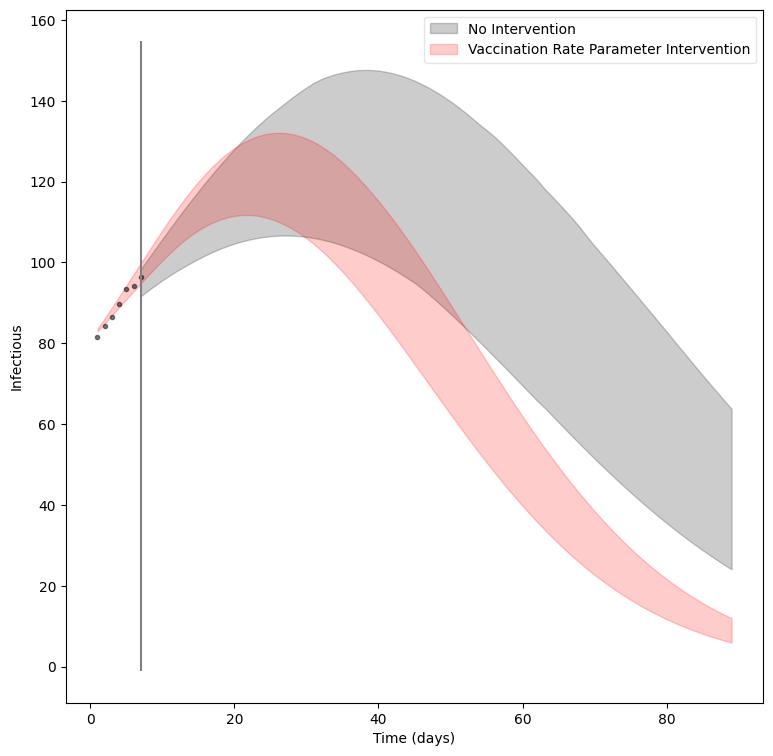

In [12]:
ax = setup_ax()
ax = plot_trajectory(plot_I_obs, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, full_tspan, tmin=7, ax=ax, label="No Intervention")
ax = plot_predictive(intervened_parameter_prediction, full_tspan, ax=ax, color='red', label="Vaccination Rate Parameter Intervention")
ax = plot_intervention_line(7., ax=ax)

# Risk-based optimization under uncertainty
## Q: "What is the minimal vaccination policy that results in less than 150 infected individuals after 90 days?"

### Problem Formulation
* **Quantity of interest**: 7-day average of total infections after 90 days
    $$M(\mathbf{u}, \theta) = \frac{1}{7}\sum_{i=0}^6 I(t=90-i;\mathbf{u},\theta)+I_\text{V}(t=90-i;\mathbf{u},\theta)$$

* **Control**: $\mathbf{u}\in \mathcal{U} \subseteq \mathbb{R}^{n_u}$
    * Vaccination rate parameter: $u=\nu$



* **Risk-based optimization under uncertainty problem formulation**
    * Objective Function - Minimize the vaccination rate.
    * Constraint - Risk of infections exceeding the prescribed threshold of 10, $\mathcal{R}( M(\mathbf{u}, \theta))$, is below the acceptable risk threshold, $\mathcal{R}_\text{threshold}$.

\begin{equation} 
\begin{split} 
\mathbf{u}^*= \underset{\mathbf{u}\in\mathcal{U}}{\arg\min}\ & \lVert \mathbf{u} \rVert_1 \\ \text{s.t.}\ & \mathcal{R}( M(\mathbf{u}, \theta)) \le \mathcal{R}_\text{threshold} 
\end{split} 
\end{equation}

## Comparing risk measures

![table_risk.png](figures/table_risk.png)

#### Adavantages of using alpha-superquantile
* Considers magnitude of infections exceeding the threshold:
    * Overcome limitations of hard thresholding
    * Desirable data-informed conservativeness
* Preserves properties of underlying quantities of interest, such as convexity

### Define optimization problem specifics (shared across optimization problems with different interventions)

In [32]:
risk_bound = 10.
n_samples_ouu = int(1e2)
u_min = 0.
u_max = 3.
init_guess = 0.02
maxfeval = 25 # Maximum number of function evaluations for each local optimization step
maxiter = 2 # Maximum number of basinhopping iterations: >0 leads to multi-start

# Plot settings
co = ['#377eb8', '#ff7f00', '#984ea3', '#ffd92f', '#a65628']
rlabel = ['Q_alpha-based OUU', 'barQ_alpha-based OUU']

### Exploring the intervention on $\nu$ and difference between Quantiles and Superquantiles

In [113]:
control_model = copy.deepcopy(initialized_petri_net_ode_model)
# Control action / intervention
# INTERVENTION = lambda x: intervene(control_model, [(7.5, "nu", torch.as_tensor(x))])
INTERVENTION= {"intervention1": [7.5, "nu"]}
QOI = lambda y: scenario2dec_sample_average(y, contexts=["I_obs"])

In [115]:
POLICY = 0.01
N_SAMPLES = 100
# TODO: check why it throws errors when rerunning without clearing: needs deepcopy for control_model
RISK = computeRisk(model=control_model,
                   interventions=INTERVENTION,
                   qoi=QOI,
                   risk_measure=alpha_superquantile,
                   num_samples=N_SAMPLES,
                   tspan=full_tspan,
                   guide=calibrated_parameters)

start_time = time.time()
sq_dataCube = RISK.propagate_uncertainty(POLICY)
end_time = time.time()
forward_time = end_time - start_time
time_per_eval = forward_time / N_SAMPLES
print(f"Forward UQ took {forward_time:.2f} seconds total ({forward_time/N_SAMPLES:.2e} seconds per model evaluation).")
# Estimate QoI
sq_qoi = RISK.qoi(sq_dataCube)
# Estimate superquantile risk
sq_sv = RISK.risk_measure(sq_qoi)
# Estimate quantile risk
RISK.risk_measure = alpha_quantile
q_sv = RISK.risk_measure(sq_qoi)
print('quantile: ', q_sv, '\nalpha-superquantile: ', sq_sv)

AssertionError: t must be strictly increasing or decreasing

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


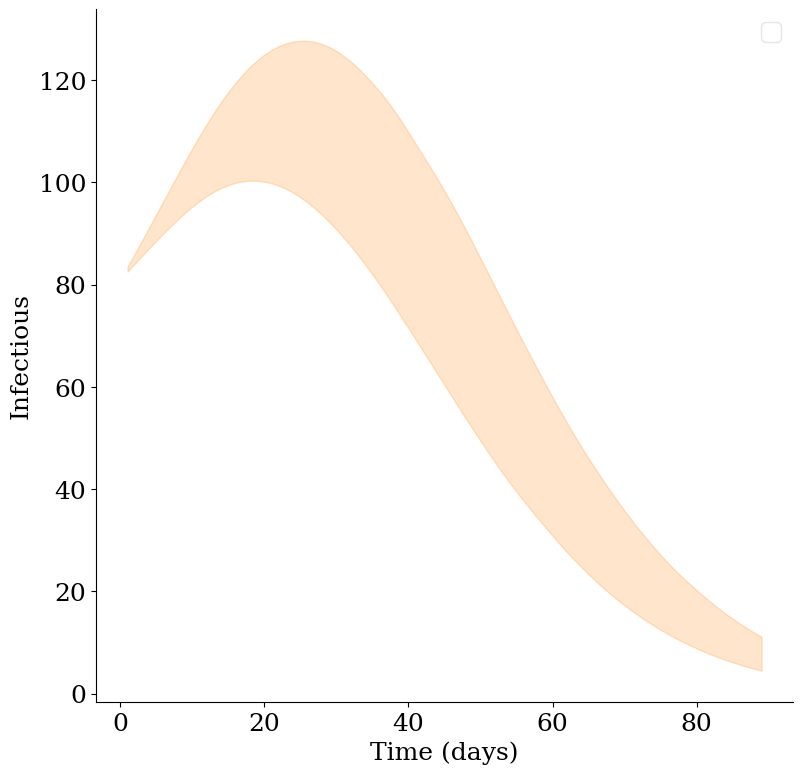

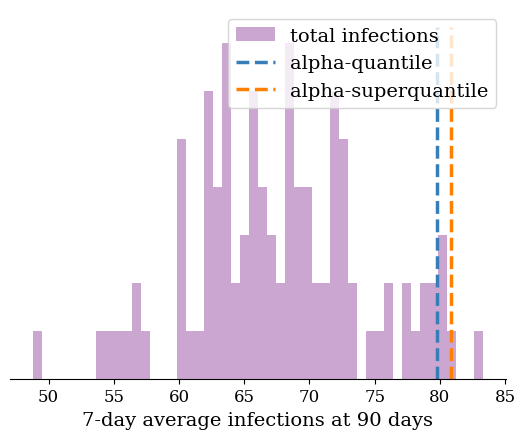

In [95]:
ax = plot_predictive(sq_dataCube, full_tspan, ax=setup_ax(), color=co[1])
sideaxis(ax)

bins_hist = 50
fig1 = plt.figure()
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=18.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(sq_qoi, color=co[2], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='total infections')
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
cax.vlines(q_sv, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-quantile', color=co[0])
cax.vlines(sq_sv, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-superquantile', color=co[1])
cax.set_xlabel('7-day average infections at 90 days', size=14)
cax.legend(loc='upper right', prop={'size': 14})

### Setup and run OUU problem
**NOTE:** This is a demonstration of the interface, optimization is not run to convergence nor are enough samples generated to accurately estimate the risk.

In [36]:
control_model = copy.deepcopy(initialized_petri_net_ode_model)

# Objective function
objfun = lambda x: np.abs(x)

# Define the risk measure.
# TODO: put RISK and CONSTRAINTS inside optimize interface
RISK = computeRisk(model=control_model,
                   interventions=INTERVENTION,
                    qoi=QOI,
                    tspan=full_tspan,
                    risk_measure=lambda z: alpha_superquantile(z, alpha=0.95),
                    num_samples=n_samples_ouu,
                    guide=calibrated_parameters
                    )

# Define problem constraints
constraints = (
                # risk constraint
                {'type': 'ineq', 'fun': lambda x: risk_bound - RISK(x)},
                # bounds on control
                {'type': 'ineq', 'fun': lambda x: x - u_min},
                {'type': 'ineq', 'fun': lambda x: u_max - x}
               )

In [37]:
print("Performing risk-based optimization under uncertainty (using alpha-superquantile)...")
print(f"Estimated wait time {time_per_eval*n_samples_ouu*(maxiter+1)*maxfeval:.1f} seconds.")
start_time = time.time()
sq_result = solveOUU(
                     x0=init_guess,
                     objfun=objfun,
                     constraints=constraints,
                     maxiter=maxiter,
                     maxfeval=maxfeval,
                    ).solve()
print(f"Optimization completed in time {time.time()-start_time:.2f} seconds. Optimal solution:\t{sq_result.x}")

# Check for some interventions that lead to no feasible solutions
if sq_result.x<0:
    print("No solution found")

Performing risk-based optimization under uncertainty (using alpha-superquantile)...
Estimated wait time 13396.5 seconds.
Optimization completed in time 10040.31 seconds. Optimal solution:	[0.01142297]


## Assess the effect of the optimal control policy under uncertainty
### Optimum value for $\nu^*=0.0117$

In [38]:
RISK.num_samples = int(1e3) # Using more samples for risk estimation
sq_optimal_prediction = RISK.propagate_uncertainty(sq_result.x)
qois_sq = RISK.qoi(sq_optimal_prediction)
sq_est = RISK.risk_measure(qois_sq)
print('Estimated risk at optimal policy', sq_est)

Estimated risk at optimal policy 10.497155380249023


[autoreload of pyciemss.risk.qoi failed: Traceback (most recent call last):
  File "c:\Users\Anirban\anaconda3\envs\askem\lib\site-packages\IPython\extensions\autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\Anirban\anaconda3\envs\askem\lib\site-packages\IPython\extensions\autoreload.py", line 471, in superreload
    module = reload(module)
  File "c:\Users\Anirban\anaconda3\envs\askem\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "C:\Users\Anirban\Documents\GitHub\pyciemss\src\pyciemss\risk\qoi.py", line 7
    def scenario2dec_nday_rolling_a

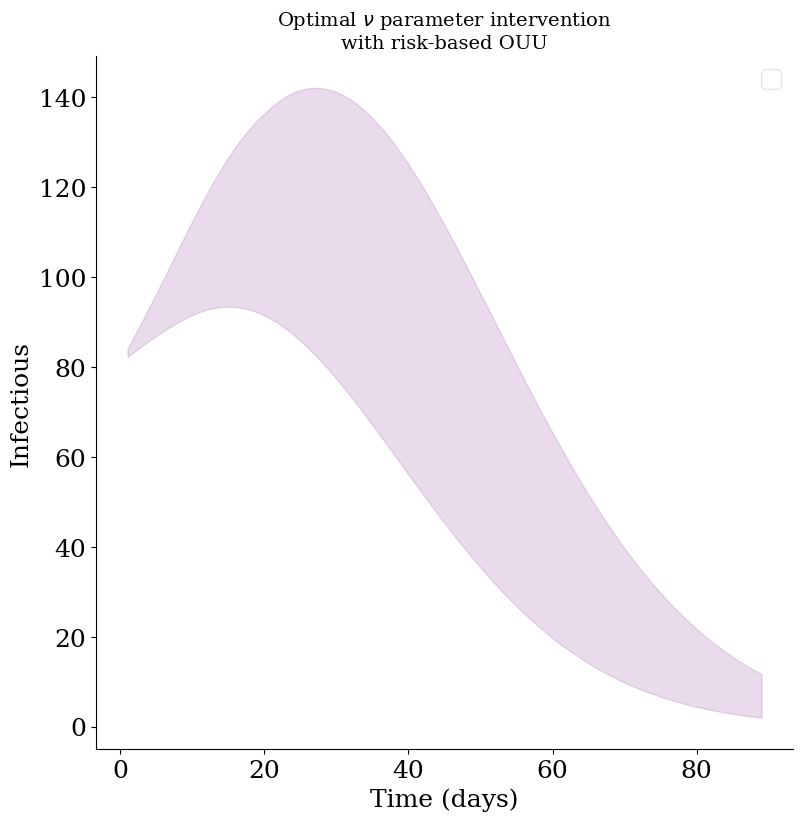

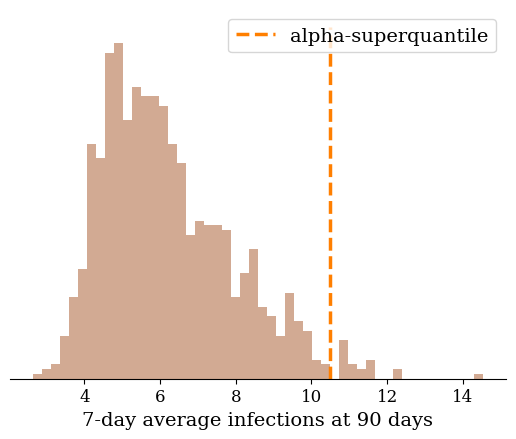

In [39]:
bins_hist = 50
ax = setup_ax()
ax = plot_predictive(sq_optimal_prediction, full_tspan, ax=ax, color=co[2], ptiles=[0.0,1.])
plt.title(r"Optimal $\nu$ parameter intervention"+ "\n" + r"with risk-based OUU", size=14)
sideaxis(ax)
fig1 = plt.figure()
plt.rc('font', family='serif', size=14.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(qois_sq, color=co[4], bins=bins_hist, histtype='stepfilled', alpha=0.5, density=True)
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
cax.vlines(sq_est, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-superquantile', color=co[1])
cax.set_xlabel('7-day average infections at 90 days', size=14)
cax.legend(loc='upper right', prop={'size': 14})

In [128]:
INTERVENTION= {"intervention1": [7.5, "nu"]}
QOI = lambda y: scenario2dec_sample_average(y, contexts=["I_obs"])
timepoints_qoi = range(83,90)
ouu_policy = optimize(initialized_petri_net_ode_model,
                   timepoints=timepoints_qoi,
                   interventions=INTERVENTION,
                   qoi=QOI,
                   risk_bound=10.,
                   initial_guess=0.02,
                   bounds=[[0.],[3.]],
                   n_samples_ouu=int(1e2),
                   maxiter=2,
                   maxfeval=25,
                   inferred_parameters=calibrated_parameters)

Time taken: (5.22e+00 seconds per model evaluation)...
Performing risk-based optimization under uncertainty (using alpha-superquantile)...
Estimated wait time 39136.4 seconds...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Optimal $\\nu$ parameter intervention\nwith risk-based OUU')

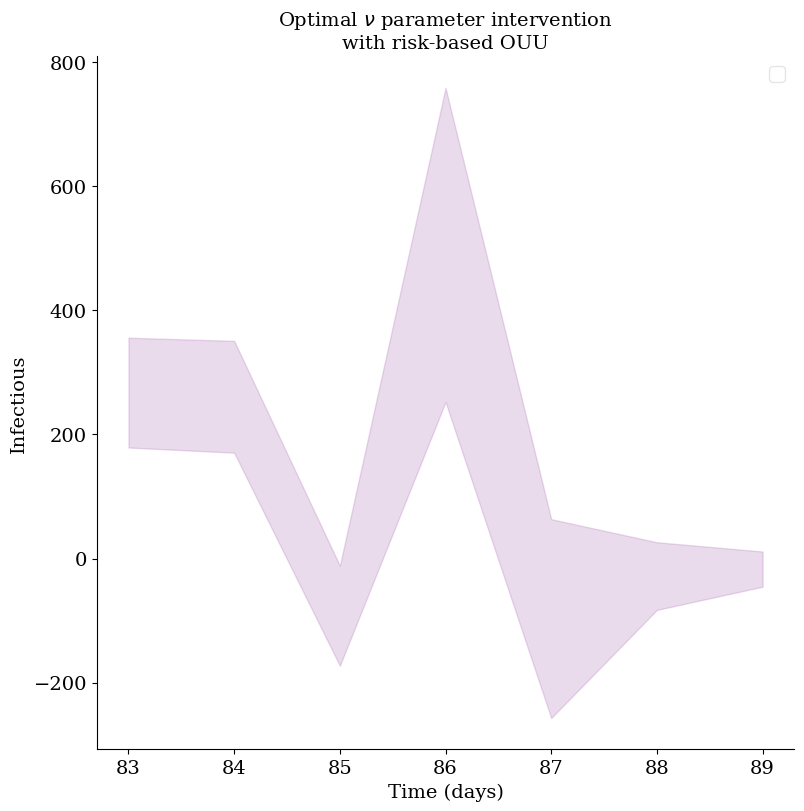

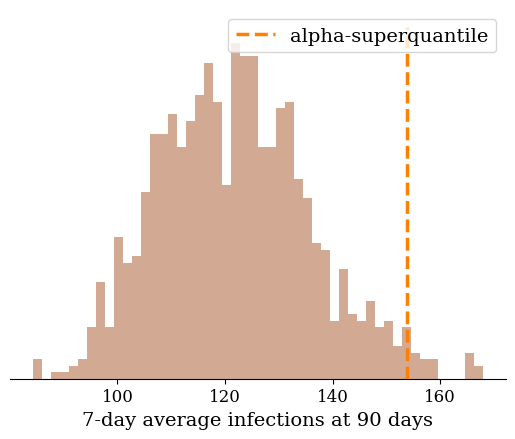

In [ ]:
ax = plot_ouu_risk(ouu_policy)
ax[0].set_title(r"Optimal $\nu$ parameter intervention"+ "\n" + r"with risk-based OUU", size=14)